# Machine Learning Trading Bot

In this Challenge, you’ll assume the role of a financial advisor at one of the top five financial advisory firms in the world. Your firm constantly competes with the other major firms to manage and automatically trade assets in a highly dynamic environment. In recent years, your firm has heavily profited by using computer algorithms that can buy and sell faster than human traders.

The speed of these transactions gave your firm a competitive advantage early on. But, people still need to specifically program these systems, which limits their ability to adapt to new data. You’re thus planning to improve the existing algorithmic trading systems and maintain the firm’s competitive advantage in the market. To do so, you’ll enhance the existing trading signals with machine learning algorithms that can adapt to new data.

## Instructions:

Use the starter code file to complete the steps that the instructions outline. The steps for this Challenge are divided into the following sections:

* Establish a Baseline Performance

* Tune the Baseline Trading Algorithm

* Evaluate a New Machine Learning Classifier

* Create an Evaluation Report

#### Establish a Baseline Performance

In this section, you’ll run the provided starter code to establish a baseline performance for the trading algorithm. To do so, complete the following steps.

Open the Jupyter notebook. Restart the kernel, run the provided cells that correspond with the first three steps, and then proceed to step four. 

1. Import the OHLCV dataset into a Pandas DataFrame.

2. Generate trading signals using short- and long-window SMA values. 

3. Split the data into training and testing datasets.

4. Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

5. Review the classification report associated with the `SVC` model predictions. 

6. Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

7. Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

8. Write your conclusions about the performance of the baseline trading algorithm in the `README.md` file that’s associated with your GitHub repository. Support your findings by using the PNG image that you saved in the previous step.

#### Tune the Baseline Trading Algorithm

In this section, you’ll tune, or adjust, the model’s input features to find the parameters that result in the best trading outcomes. (You’ll choose the best by comparing the cumulative products of the strategy returns.) To do so, complete the following steps:

1. Tune the training algorithm by adjusting the size of the training dataset. To do so, slice your data into different periods. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. Answer the following question: What impact resulted from increasing or decreasing the training window?

> **Hint** To adjust the size of the training dataset, you can use a different `DateOffset` value&mdash;for example, six months. Be aware that changing the size of the training dataset also affects the size of the testing dataset.

2. Tune the trading algorithm by adjusting the SMA input features. Adjust one or both of the windows for the algorithm. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. Answer the following question: What impact resulted from increasing or decreasing either or both of the SMA windows?

3. Choose the set of parameters that best improved the trading algorithm returns. Save a PNG image of the cumulative product of the actual returns vs. the strategy returns, and document your conclusion in your `README.md` file.

#### Evaluate a New Machine Learning Classifier

In this section, you’ll use the original parameters that the starter code provided. But, you’ll apply them to the performance of a second machine learning model. To do so, complete the following steps:

1. Import a new classifier, such as `AdaBoost`, `DecisionTreeClassifier`, or `LogisticRegression`. (For the full list of classifiers, refer to the [Supervised learning page](https://scikit-learn.org/stable/supervised_learning.html) in the scikit-learn documentation.)

2. Using the original training data as the baseline model, fit another model with the new classifier.

3. Backtest the new model to evaluate its performance. Save a PNG image of the cumulative product of the actual returns vs. the strategy returns for this updated trading algorithm, and write your conclusions in your `README.md` file. Answer the following questions: Did this new model perform better or worse than the provided baseline model? Did this new model perform better or worse than your tuned trading algorithm?

#### Create an Evaluation Report

In the previous sections, you updated your `README.md` file with your conclusions. To accomplish this section, you need to add a summary evaluation report at the end of the `README.md` file. For this report, express your final conclusions and analysis. Support your findings by using the PNG images that you created.


In [80]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


---

## Establish a Baseline Performance

In this section, you’ll run the provided starter code to establish a baseline performance for the trading algorithm. To do so, complete the following steps.

Open the Jupyter notebook. Restart the kernel, run the provided cells that correspond with the first three steps, and then proceed to step four. 


### Step 1: Import the OHLCV dataset into a Pandas DataFrame.

In [81]:
# Import the OHLCV dataset into a Pandas Dataframe
ohlcv_df = pd.read_csv(
    Path("../data/emerging_markets_ohlcv.csv"), 
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
ohlcv_df.head()

,open,high,low,close,volume
date,,,,,
2015-01-21 09:30:00,23.83,23.83,23.83,23.83,100
2015-01-21 11:00:00,23.98,23.98,23.98,23.98,100
2015-01-22 15:00:00,24.42,24.42,24.42,24.42,100
2015-01-22 15:15:00,24.42,24.44,24.42,24.44,200
2015-01-22 15:30:00,24.46,24.46,24.46,24.46,200


In [82]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ["close"]]

# Use the pct_change function to generate returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
date,,
2015-01-21 11:00:00,23.98,0.006295
2015-01-22 15:00:00,24.42,0.018349
2015-01-22 15:15:00,24.44,0.000819
2015-01-22 15:30:00,24.46,0.000818
2015-01-26 12:30:00,24.33,-0.005315


,close,Actual Returns
date,,
2021-01-22 09:30:00,33.27,-0.006866
2021-01-22 11:30:00,33.35,0.002405
2021-01-22 13:45:00,33.42,0.002099
2021-01-22 14:30:00,33.47,0.001496
2021-01-22 15:45:00,33.44,-0.000896


## Step 2: Generate trading signals using short- and long-window SMA values. 

In [83]:
# Set the short window and long window
short_window = 50
long_window = 200

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2015-06-12 10:00:00,24.38,0.001232,25.2254,24.88590
2015-06-12 10:15:00,24.33,-0.002051,25.1916,24.88765
2015-06-12 11:00:00,24.25,-0.003288,25.1574,24.88680
2015-06-12 11:45:00,24.36,0.004536,25.1252,24.88640
2015-06-15 10:15:00,24.06,-0.012315,25.0862,24.88440


,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2021-01-22 09:30:00,33.27,-0.006866,31.2232,29.05610
2021-01-22 11:30:00,33.35,0.002405,31.2848,29.08625
2021-01-22 13:45:00,33.42,0.002099,31.3480,29.11665
2021-01-22 14:30:00,33.47,0.001496,31.4132,29.14690
2021-01-22 15:45:00,33.44,-0.000896,31.4768,29.17835


In [84]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2015-06-12 10:00:00,24.38,0.001232,25.2254,24.88590,1.0
2015-06-12 10:15:00,24.33,-0.002051,25.1916,24.88765,-1.0
2015-06-12 11:00:00,24.25,-0.003288,25.1574,24.88680,-1.0
2015-06-12 11:45:00,24.36,0.004536,25.1252,24.88640,1.0
2015-06-15 10:15:00,24.06,-0.012315,25.0862,24.88440,-1.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2021-01-22 09:30:00,33.27,-0.006866,31.2232,29.05610,-1.0
2021-01-22 11:30:00,33.35,0.002405,31.2848,29.08625,1.0
2021-01-22 13:45:00,33.42,0.002099,31.3480,29.11665,1.0
2021-01-22 14:30:00,33.47,0.001496,31.4132,29.14690,1.0
2021-01-22 15:45:00,33.44,-0.000896,31.4768,29.17835,-1.0


In [85]:
# Calculate the points in time at which a position should be taken, 1 or -1
signals_df['Entry/Exit'] = signals_df['Signal'].diff()


In [86]:
# Visualize entry positions relative to close price
entry = signals_df[signals_df['Entry/Exit'] == 1.0]['close'].hvplot.scatter(
    color='purple',
    marker='^',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize exit positions relative to close price
exit = signals_df[signals_df['Entry/Exit'] == -1.0]['close'].hvplot.scatter(
    color='orange',
    marker='v',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize the close price for the investment
security_close = signals_df[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize the moving averages
moving_avgs = signals_df[['SMA_Fast', 'SMA_Slow']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay the plots
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(
    title="VNQ - Short-Position Dual Moving Average Trading Algorithm"
)

:Overlay
   .Curve.I          :Curve   [date]   (close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [date]   (value)
   .Scatter.Close.I  :Scatter   [date]   (close)
   .Scatter.Close.II :Scatter   [date]   (close)

In [87]:
signals_df['Signal'].value_counts()

 1.0    2304
-1.0    1819
Name: Signal, dtype: int64

In [88]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Entry/Exit,Strategy Returns
date,,,,,,,
2015-06-12 10:00:00,24.38,0.001232,25.2254,24.88590,1.0,NaN,NaN
2015-06-12 10:15:00,24.33,-0.002051,25.1916,24.88765,-1.0,-2.0,-0.002051
2015-06-12 11:00:00,24.25,-0.003288,25.1574,24.88680,-1.0,0.0,0.003288
2015-06-12 11:45:00,24.36,0.004536,25.1252,24.88640,1.0,2.0,-0.004536
2015-06-15 10:15:00,24.06,-0.012315,25.0862,24.88440,-1.0,-2.0,-0.012315


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Entry/Exit,Strategy Returns
date,,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,31.2232,29.05610,-1.0,-2.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,31.2848,29.08625,1.0,2.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,31.3480,29.11665,1.0,0.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,31.4132,29.14690,1.0,0.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,31.4768,29.17835,-1.0,-2.0,-0.000896


<AxesSubplot:xlabel='date'>

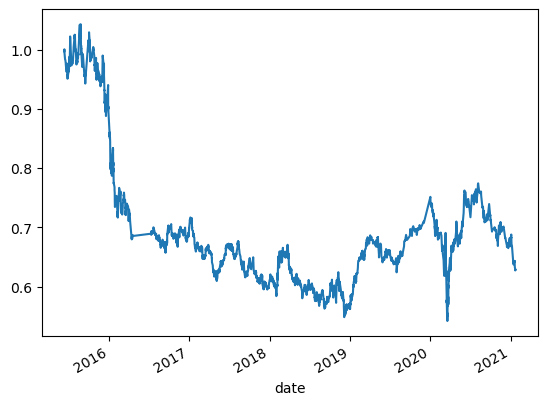

In [89]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

### Step 3: Split the data into training and testing datasets.

In [90]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
rows = 3
display(X.head(rows))
display(X.tail(rows))


,SMA_Fast,SMA_Slow
date,,
2015-06-12 10:15:00,25.2254,24.88590
2015-06-12 11:00:00,25.1916,24.88765
2015-06-12 11:45:00,25.1574,24.88680


,SMA_Fast,SMA_Slow
date,,
2021-01-22 13:45:00,31.2848,29.08625
2021-01-22 14:30:00,31.3480,29.11665
2021-01-22 15:45:00,31.4132,29.14690


In [91]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

 1.0    2304
-1.0    1819
Name: Signal, dtype: int64

In [92]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-06-12 10:15:00


In [93]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=6)

# Display the training end date
print(training_end)

2015-12-12 10:15:00


In [94]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
rows = 3
display(X_train.head(rows))
display(X_train.tail(rows))


,SMA_Fast,SMA_Slow
date,,
2015-06-12 10:15:00,25.2254,24.88590
2015-06-12 11:00:00,25.1916,24.88765
2015-06-12 11:45:00,25.1574,24.88680


,SMA_Fast,SMA_Slow
date,,
2015-12-11 15:00:00,20.6378,21.65335
2015-12-11 15:30:00,20.6000,21.64945
2015-12-11 15:45:00,20.5606,21.64520


In [95]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
date,,
2015-06-12 10:15:00,25.2254,24.88590
2015-06-12 11:00:00,25.1916,24.88765
2015-06-12 11:45:00,25.1574,24.88680
2015-06-15 10:15:00,25.1252,24.88640
2015-06-16 15:45:00,25.0862,24.88440


In [96]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Step 4: Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

In [97]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred[:10]


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Step 5: Review the classification report associated with the `SVC` model predictions. 

In [98]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)


              precision    recall  f1-score   support

        -1.0       0.45      0.28      0.35      1651
         1.0       0.57      0.73      0.64      2120

    accuracy                           0.54      3771
   macro avg       0.51      0.51      0.49      3771
weighted avg       0.52      0.54      0.51      3771



### Step 6: Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [99]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred
print(f'SVM Predictions Count: \n{predictions_df["Predicted"].value_counts()}')

# Add the actual returns to the DataFrame
predictions_df['Actual_Returns'] = signals_df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_df['Strategy_Returns'] = predictions_df["Actual_Returns"] * predictions_df["Predicted"]

# Review the DataFrame
rows = 3
display(predictions_df.head(rows))
display(predictions_df.tail(rows))



SVM Predictions Count: 
 1.0    2739
-1.0    1032
Name: Predicted, dtype: int64


,Predicted,Actual_Returns,Strategy_Returns
date,,,
2015-12-14 09:30:00,1.0,0.005074,0.005074
2015-12-14 12:45:00,1.0,-0.003534,-0.003534
2015-12-14 13:00:00,1.0,0.005572,0.005572


,Predicted,Actual_Returns,Strategy_Returns
date,,,
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


### Step 7: Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

### Plot the actual returns versus the strategy returns
(1 + predictions_df[["Actual_Returns", "Strategy_Returns"]]).cumprod().plot()


In [104]:
# Plot the actual returns versus the strategy returns
a = (1 + predictions_df[["Actual_Returns", "Strategy_Returns"]]).cumprod()
a.iloc[-1]

Actual_Returns      1.696601
Strategy_Returns    1.550366
Name: 2021-01-22 15:45:00, dtype: float64

---

## Tune the Baseline Trading Algorithm

In this section, you’ll tune, or adjust, the model’s input features to find the parameters that result in the best trading outcomes. You’ll choose the best by comparing the cumulative products of the strategy returns.

### Step 1: Tune the training algorithm by adjusting the size of the training dataset. 

To do so, slice your data into different periods. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. 

Answer the following question: What impact resulted from increasing or decreasing the training window?

In [51]:
# Tune based on Training Time Frame

# Initialize lists 
list_training_months = []
list_accuracy_test = [] 
list_training_begin = []
list_training_end = []
list_test_length = []
list_svm_testing_report = []
list_tn = [] 
list_fp = [] 
list_fn = [] 
list_tp = []

  
for training_months in range(1,25):
    list_training_months.append(training_months)
    
    # Select the start of the training period
    training_begin = X.index.min()
    list_training_begin.append(training_begin)
    
    # Select the ending period for the training data with an offset of 3 months
    training_end = X.index.min() + DateOffset(months=training_months)
    list_training_end.append(training_end)
    
    # Generate the X_train and y_train DataFrames
    X_train = X.loc[training_begin:training_end]
    y_train = y.loc[training_begin:training_end]
    
    # Generate the X_test and y_test DataFrames
    X_test = X.loc[training_end + DateOffset(hours=1) : ]
    y_test = y.loc[training_end + DateOffset(hours=1) : ]
    list_test_length.append(X_test.shape)
    
    # Apply the scaler model to fit the X-train data
    X_scaler = scaler.fit(X_train)

    # Transform the X_train and X_test DataFrames using the X_scaler
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    # From SVM, instantiate SVC classifier model instance
    svm_model = svm.SVC()
    
    # Fit the model to the data using the training data
    svm_model = svm_model.fit(X_train_scaled, y_train)
 
    # Use the testing data to make the model predictions
    svm_pred = svm_model.predict(X_test_scaled)
    
    # Use a classification report to evaluate the model using the predictions and testing data
    svm_testing_report = classification_report(y_test, svm_pred, zero_division = 1)
    list_svm_testing_report.append(svm_testing_report)
    
    accuracy_score_test = accuracy_score(y_test, svm_pred)
    list_accuracy_test.append(accuracy_score_test)
    
    
    tn, fp, fn, tp = confusion_matrix(y_test, svm_pred).ravel()
    list_tn.append(tn)
    list_fp.append(fp)
    list_fn.append(fn)
    list_tp.append(tp)
    
    del X_train, y_train, X_scaler, X_train_scaled, X_test_scaled, svm_model, svm_pred, svm_testing_report, accuracy_score_test

    # Store the model results in a data frame
df_results = pd.DataFrame({'training_months'    : list_training_months, 
                          'training_begin'      : list_training_begin, 
                          'training_end'        : list_training_end,
                          'test_length'         : list_test_length,
                          'svm_testing_report'  : list_svm_testing_report,
                          'accuracy_score_test' : list_accuracy_test,
                          'tn' : list_tn,
                          'fp' : list_fp,
                          'fn' : list_fn, 
                          'tp' : list_tp 
                          })

df_results = df_results.reset_index()  # make sure indexes pair with number of rows

del list_training_months, list_training_begin, list_training_end, list_svm_testing_report, list_test_length, list_accuracy_test
del list_tn, list_fp, list_fn, list_tp

# Review the DataFrame
rows = 3
display(df_results.head(rows))
display(df_results.tail(rows))


,index,training_months,training_begin,training_end,test_length,svm_testing_report,accuracy_score_test,tn,fp,fn,tp
0,0,1,2015-04-02 15:00:00,2015-05-02 15:00:00,"(4152, 2)",precision recall f1-score ...,0.549855,61,1767,102,2222
1,1,2,2015-04-02 15:00:00,2015-06-02 15:00:00,"(4143, 2)",precision recall f1-score ...,0.550567,64,1761,101,2217
2,2,3,2015-04-02 15:00:00,2015-07-02 15:00:00,"(4092, 2)",precision recall f1-score ...,0.553519,69,1735,92,2196


,index,training_months,training_begin,training_end,test_length,svm_testing_report,accuracy_score_test,tn,fp,fn,tp
21,21,22,2015-04-02 15:00:00,2017-02-02 15:00:00,"(2943, 2)",precision recall f1-score ...,0.560652,45,1245,48,1605
22,22,23,2015-04-02 15:00:00,2017-03-02 15:00:00,"(2892, 2)",precision recall f1-score ...,0.562932,63,1203,61,1565
23,23,24,2015-04-02 15:00:00,2017-04-02 15:00:00,"(2794, 2)",precision recall f1-score ...,0.561203,4,1225,1,1564


In [50]:
# View testing reports

for index, row in df_results.iterrows():
    print(f"Months: {row['training_months']}  Length: {row['test_length'][0]}  Accuracy: {row['accuracy_score_test']:.4f}  TP: {row['tp']}  FP: {row['fp']}  TN: {row['tn']}  FN: {row['fn']}")
    #print(row['accuracy_score_test'])
    

Months: 1  Length: 4152  Accuracy: 0.5499  TP: 2222  FP: 1767  TN: 61  FN: 102
Months: 2  Length: 4143  Accuracy: 0.5506  TP: 2217  FP: 1761  TN: 64  FN: 101
Months: 3  Length: 4092  Accuracy: 0.5535  TP: 2196  FP: 1735  TN: 69  FN: 92
Months: 4  Length: 4049  Accuracy: 0.5542  TP: 2172  FP: 1707  TN: 72  FN: 98
Months: 5  Length: 3977  Accuracy: 0.5567  TP: 2133  FP: 1664  TN: 81  FN: 99
Months: 6  Length: 3943  Accuracy: 0.5582  TP: 2163  FP: 1694  TN: 38  FN: 48
Months: 7  Length: 3882  Accuracy: 0.5556  TP: 2068  FP: 1618  TN: 89  FN: 107
Months: 8  Length: 3812  Accuracy: 0.5391  TP: 1780  FP: 1395  TN: 275  FN: 362
Months: 9  Length: 3704  Accuracy: 0.5316  TP: 1464  FP: 1111  TN: 505  FN: 624
Months: 10  Length: 3566  Accuracy: 0.5620  TP: 1965  FP: 1510  TN: 39  FN: 52
Months: 11  Length: 3501  Accuracy: 0.5644  TP: 1976  FP: 1525  TN: 0  FN: 0
Months: 12  Length: 3428  Accuracy: 0.5633  TP: 1931  FP: 1497  TN: 0  FN: 0
Months: 13  Length: 3405  Accuracy: 0.5642  TP: 1921  FP: 

> Note: Time permitting I would have dove further into this determination by looking at other confusion matrix driven metrics

> **What impact resulted from increasing or decreasing the training window?**  
> I would choose 8 months because it is more balanced that other periods and has higher accuracy than 9 months. 

### Step 2: Tune the trading algorithm by adjusting the SMA input features. 

Adjust one or both of the windows for the algorithm. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. 

Answer the following question: What impact resulted from increasing or decreasing either or both of the SMA windows?

In [59]:
# Filter the date index and close columns
signals_df_2 = ohlcv_df.loc[:, ["close"]]

# Use the pct_change function to generate returns from close prices
signals_df_2["Actual Returns"] = signals_df_2["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df_2 = signals_df_2.dropna()

# Review the DataFrame
display(signals_df_2.head())
display(signals_df_2.tail())

,close,Actual Returns
date,,
2015-01-21 11:00:00,23.98,0.006295
2015-01-22 15:00:00,24.42,0.018349
2015-01-22 15:15:00,24.44,0.000819
2015-01-22 15:30:00,24.46,0.000818
2015-01-26 12:30:00,24.33,-0.005315


,close,Actual Returns
date,,
2021-01-22 09:30:00,33.27,-0.006866
2021-01-22 11:30:00,33.35,0.002405
2021-01-22 13:45:00,33.42,0.002099
2021-01-22 14:30:00,33.47,0.001496
2021-01-22 15:45:00,33.44,-0.000896


In [79]:
# Set the short window and long window
#short_window = 4
#long_window = 100

# Initialize lists 
list_loop_index = []
list_short_window = []
list_long_window = [] 
list_strategy_return = []
list_training_end = []
list_test_length = []
list_svm_testing_report = []

loop_index = 0

for short_window in range (5, 101, 5):                        # Vary short_window from 5 to 100 by 5
    # Filter the date index and close columns
    signals_df_2 = ohlcv_df.loc[:, ["close"]]

    # Use the pct_change function to generate returns from close prices
    signals_df_2["Actual Returns"] = signals_df_2["close"].pct_change()

    # Drop all NaN values from the DataFrame
    signals_df_2 = signals_df_2.dropna()
        
    long_start = max(short_window + 50, 100)                  # Ensure a minimum gap of 50 between short_window and long_window
    
    for long_window in range (long_start, 261, 10):           # Vary long_window from 100 to 260 (aprox 1 year)
        print(f'Short: {short_window}; Long {long_window}')
        
        loop_index += 1
        list_loop_index.append(loop_index)
        
        list_short_window.append(short_window)
        list_long_window.append(long_window)

        # Generate the fast and slow simple moving averages (4 and 100 days, respectively)
        signals_df_2['SMA_Fast'] = signals_df_2['close'].rolling(window=short_window).mean()
        signals_df_2['SMA_Slow'] = signals_df_2['close'].rolling(window=long_window).mean()

        signals_df_2 = signals_df_2.dropna()
        
        # Review the DataFrame
        #display(signals_df.head())
        #display(signals_df.tail())

        # Initialize the new Signal column
        signals_df_2['Signal'] = 0.0

        # When Actual Returns are greater than or equal to 0, generate signal to buy stock long
        signals_df_2.loc[(signals_df_2['Actual Returns'] >= 0), 'Signal'] = 1

        # When Actual Returns are less than 0, generate signal to sell stock short
        signals_df_2.loc[(signals_df_2['Actual Returns'] < 0), 'Signal'] = -1

        # Review the DataFrame
        #display(signals_df_2.head())
        #display(signals_df_2.tail())
        
        # Calculate the points in time at which a position should be taken, 1 or -1
        signals_df_2['Entry/Exit'] = signals_df_2['Signal'].diff()
        
        # Calculate the strategy returns and add them to the signals_df DataFrame
        signals_df_2['Strategy Returns'] = signals_df_2['Actual Returns'] * signals_df_2['Signal'].shift()

        # Review the DataFrame
        #display(signals_df_2.head())
        #display(signals_df_2.tail())
        #display(signals_df_2[-1:])
        
        # Plot Strategy Returns to examine performance
        strategy_return = ((1 + signals_df['Strategy Returns']).cumprod())
        display(strategy_return)
        list_strategy_return.append(strategy_return[-1])
        
        #del X_train, y_train, X_scaler, X_train_scaled, X_test_scaled, svm_model, svm_pred, svm_testing_report, accuracy_score_test

        # Store the model results in a data frame
df_results_2 = pd.DataFrame({'short_window'        : list_short_window, 
                                     'long_window'         : list_long_window, 
                                     'strategy_return'     : list_strategy_return[-1],
                                     #'test_length'         : list_test_length,
                                     #'svm_testing_report'  : list_svm_testing_report,
                                     #'accuracy_score_test' : list_accuracy_test,
                                     #'tn'                  : list_tn,
                                     #'fp'                  : list_fp,
                                     #'fn'                  : list_fn, 
                                     'tp'                  : list_loop_index 
                                     })
        
        
df_results_2        
        



Short: 5; Long 100


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 5; Long 110


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 5; Long 120


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 5; Long 130


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 5; Long 140


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 5; Long 150


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 5; Long 160


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 5; Long 170


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 5; Long 180


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 5; Long 190


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 5; Long 200


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 5; Long 210


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 5; Long 220


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 5; Long 230


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 5; Long 240


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 5; Long 250


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 5; Long 260


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 10; Long 100


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 10; Long 110


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 10; Long 120


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 10; Long 130


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 10; Long 140


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 10; Long 150


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 10; Long 160


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 10; Long 170


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 10; Long 180


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 10; Long 190


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 10; Long 200


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 10; Long 210


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 10; Long 220


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 10; Long 230


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 10; Long 240


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 10; Long 250


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 10; Long 260


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 15; Long 100


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 15; Long 110


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 15; Long 120


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 15; Long 130


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 15; Long 140


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 15; Long 150


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 15; Long 160


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 15; Long 170


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 15; Long 180


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 15; Long 190


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 15; Long 200


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 15; Long 210


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 15; Long 220


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 15; Long 230


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 15; Long 240


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 15; Long 250


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 15; Long 260


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 20; Long 100


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 20; Long 110


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 20; Long 120


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 20; Long 130


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 20; Long 140


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 20; Long 150


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 20; Long 160


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 20; Long 170


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 20; Long 180


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 20; Long 190


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 20; Long 200


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 20; Long 210


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 20; Long 220


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 20; Long 230


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 20; Long 240


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 20; Long 250


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 20; Long 260


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 25; Long 100


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 25; Long 110


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 25; Long 120


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 25; Long 130


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 25; Long 140


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 25; Long 150


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 25; Long 160


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 25; Long 170


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 25; Long 180


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 25; Long 190


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 25; Long 200


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 25; Long 210


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 25; Long 220


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 25; Long 230


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 25; Long 240


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 25; Long 250


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 25; Long 260


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 30; Long 100


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 30; Long 110


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 30; Long 120


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 30; Long 130


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 30; Long 140


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 30; Long 150


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 30; Long 160


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 30; Long 170


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 30; Long 180


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 30; Long 190


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 30; Long 200


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 30; Long 210


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 30; Long 220


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 30; Long 230


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 30; Long 240


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 30; Long 250


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 30; Long 260


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 35; Long 100


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 35; Long 110


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 35; Long 120


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 35; Long 130


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 35; Long 140


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 35; Long 150


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 35; Long 160


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 35; Long 170


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 35; Long 180


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 35; Long 190


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 35; Long 200


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 35; Long 210


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 35; Long 220


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 35; Long 230


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 35; Long 240


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 35; Long 250


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 35; Long 260


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 40; Long 100


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 40; Long 110


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 40; Long 120


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 40; Long 130


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 40; Long 140


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 40; Long 150


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 40; Long 160


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 40; Long 170


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 40; Long 180


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 40; Long 190


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 40; Long 200


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 40; Long 210


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 40; Long 220


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 40; Long 230


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 40; Long 240


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 40; Long 250


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 40; Long 260


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 45; Long 100


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 45; Long 110


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 45; Long 120


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 45; Long 130


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 45; Long 140


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 45; Long 150


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 45; Long 160


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 45; Long 170


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 45; Long 180


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 45; Long 190


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 45; Long 200


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 45; Long 210


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 45; Long 220


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 45; Long 230


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 45; Long 240


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 45; Long 250


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 45; Long 260


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 50; Long 100


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 50; Long 110


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 50; Long 120


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 50; Long 130


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 50; Long 140


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 50; Long 150


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 50; Long 160


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 50; Long 170


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 50; Long 180


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 50; Long 190


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 50; Long 200


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 50; Long 210


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 50; Long 220


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 50; Long 230


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 50; Long 240


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 50; Long 250


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 50; Long 260


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 55; Long 105


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 55; Long 115


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 55; Long 125


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 55; Long 135


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 55; Long 145


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 55; Long 155


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 55; Long 165


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 55; Long 175


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 55; Long 185


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 55; Long 195


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 55; Long 205


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 55; Long 215


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 55; Long 225


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 55; Long 235


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 55; Long 245


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 55; Long 255


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 60; Long 110


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 60; Long 120


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 60; Long 130


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 60; Long 140


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 60; Long 150


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 60; Long 160


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 60; Long 170


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 60; Long 180


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 60; Long 190


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 60; Long 200


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 60; Long 210


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 60; Long 220


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 60; Long 230


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 60; Long 240


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 60; Long 250


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 60; Long 260


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 65; Long 115


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 65; Long 125


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 65; Long 135


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 65; Long 145


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 65; Long 155


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 65; Long 165


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 65; Long 175


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 65; Long 185


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 65; Long 195


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 65; Long 205


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 65; Long 215


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 65; Long 225


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 65; Long 235


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 65; Long 245


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 65; Long 255


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 70; Long 120


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 70; Long 130


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 70; Long 140


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 70; Long 150


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 70; Long 160


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 70; Long 170


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 70; Long 180


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 70; Long 190


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 70; Long 200


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 70; Long 210


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 70; Long 220


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 70; Long 230


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 70; Long 240


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 70; Long 250


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 70; Long 260


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 75; Long 125


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 75; Long 135


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 75; Long 145


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 75; Long 155


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 75; Long 165


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 75; Long 175


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 75; Long 185


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 75; Long 195


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 75; Long 205


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 75; Long 215


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 75; Long 225


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 75; Long 235


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 75; Long 245


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 75; Long 255


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 80; Long 130


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 80; Long 140


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 80; Long 150


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 80; Long 160


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 80; Long 170


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 80; Long 180


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 80; Long 190


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 80; Long 200


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 80; Long 210


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 80; Long 220


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 80; Long 230


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 80; Long 240


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 80; Long 250


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 80; Long 260


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 85; Long 135


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 85; Long 145


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 85; Long 155


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 85; Long 165


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 85; Long 175


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 85; Long 185


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 85; Long 195


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 85; Long 205


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 85; Long 215


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 85; Long 225


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 85; Long 235


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 85; Long 245


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 85; Long 255


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 90; Long 140


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 90; Long 150


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 90; Long 160


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 90; Long 170


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 90; Long 180


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 90; Long 190


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 90; Long 200


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 90; Long 210


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 90; Long 220


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 90; Long 230


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 90; Long 240


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 90; Long 250


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 90; Long 260


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 95; Long 145


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 95; Long 155


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 95; Long 165


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 95; Long 175


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 95; Long 185


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 95; Long 195


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 95; Long 205


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 95; Long 215


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 95; Long 225


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 95; Long 235


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 95; Long 245


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 95; Long 255


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 100; Long 150


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 100; Long 160


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 100; Long 170


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 100; Long 180


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 100; Long 190


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 100; Long 200


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 100; Long 210


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 100; Long 220


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 100; Long 230


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 100; Long 240


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 100; Long 250


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

Short: 100; Long 260


date
2016-02-29 11:30:00    1.012612
2016-02-29 12:15:00    1.011561
2016-02-29 15:45:00    1.018392
2016-03-01 10:00:00    0.996554
2016-03-01 15:30:00    1.000636
                         ...   
2021-01-22 09:30:00    0.868111
2021-01-22 11:30:00    0.866023
2021-01-22 13:45:00    0.867841
2021-01-22 14:30:00    0.869140
2021-01-22 15:45:00    0.868360
Name: Strategy Returns, Length: 3507, dtype: float64

,short_window,long_window,strategy_return,tp
0,5,100,0.86836,1
1,5,110,0.86836,2
2,5,120,0.86836,3
3,5,130,0.86836,4
4,5,140,0.86836,5
...,...,...,...,...
305,100,220,0.86836,306
306,100,230,0.86836,307
307,100,240,0.86836,308
308,100,250,0.86836,309


In [ ]:
# Tune based on Training Time Frame

# Initialize lists 
list_training_months = []
list_accuracy_test = [] 
list_training_begin = []
list_training_end = []
list_test_length = []
list_svm_testing_report = []
list_tn = [] 
list_fp = [] 
list_fn = [] 
list_tp = []

  
for training_months in range(1,25):
    list_training_months.append(training_months)
    
    # Select the start of the training period
    training_begin = X.index.min()
    list_training_begin.append(training_begin)
    
    # Select the ending period for the training data with an offset of 3 months
    training_end = X.index.min() + DateOffset(months=training_months)
    list_training_end.append(training_end)
    
    # Generate the X_train and y_train DataFrames
    X_train = X.loc[training_begin:training_end]
    y_train = y.loc[training_begin:training_end]
    
    # Generate the X_test and y_test DataFrames
    X_test = X.loc[training_end + DateOffset(hours=1) : ]
    y_test = y.loc[training_end + DateOffset(hours=1) : ]
    list_test_length.append(X_test.shape)
    
    # Apply the scaler model to fit the X-train data
    X_scaler = scaler.fit(X_train)

    # Transform the X_train and X_test DataFrames using the X_scaler
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    # From SVM, instantiate SVC classifier model instance
    svm_model = svm.SVC()
    
    # Fit the model to the data using the training data
    svm_model = svm_model.fit(X_train_scaled, y_train)
 
    # Use the testing data to make the model predictions
    svm_pred = svm_model.predict(X_test_scaled)
    
    # Use a classification report to evaluate the model using the predictions and testing data
    svm_testing_report = classification_report(y_test, svm_pred, zero_division = 1)
    list_svm_testing_report.append(svm_testing_report)
    
    accuracy_score_test = accuracy_score(y_test, svm_pred)
    list_accuracy_test.append(accuracy_score_test)
    
    
    tn, fp, fn, tp = confusion_matrix(y_test, svm_pred).ravel()
    list_tn.append(tn)
    list_fp.append(fp)
    list_fn.append(fn)
    list_tp.append(tp)
    
    del X_train, y_train, X_scaler, X_train_scaled, X_test_scaled, svm_model, svm_pred, svm_testing_report, accuracy_score_test

    # Store the model results in a data frame
df_results = pd.DataFrame({'training_months'    : list_training_months, 
                          'training_begin'      : list_training_begin, 
                          'training_end'        : list_training_end,
                          'test_length'         : list_test_length,
                          'svm_testing_report'  : list_svm_testing_report,
                          'accuracy_score_test' : list_accuracy_test,
                          'tn' : list_tn,
                          'fp' : list_fp,
                          'fn' : list_fn, 
                          'tp' : list_tp 
                          })

df_results = df_results.reset_index()  # make sure indexes pair with number of rows

del list_training_months, list_training_begin, list_training_end, list_svm_testing_report, list_test_length, list_accuracy_test
del list_tn, list_fp, list_fn, list_tp

# Review the DataFrame
rows = 3
display(df_results.head(rows))
display(df_results.tail(rows))

### Step 3: Choose the set of parameters that best improved the trading algorithm returns. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns, and document your conclusion in your `README.md` file.

---

## Evaluate a New Machine Learning Classifier

In this section, you’ll use the original parameters that the starter code provided. But, you’ll apply them to the performance of a second machine learning model. 

### Step 1:  Import a new classifier, such as `AdaBoost`, `DecisionTreeClassifier`, or `LogisticRegression`. (For the full list of classifiers, refer to the [Supervised learning page](https://scikit-learn.org/stable/supervised_learning.html) in the scikit-learn documentation.)

In [20]:
# Import a new classifier from SKLearn
from sklearn import tree

# Initiate the model instance
dtc_model = tree.DecisionTreeClassifier()


### Step 2: Using the original training data as the baseline model, fit another model with the new classifier.

In [21]:
# Fit the model using the training data
dtc_model = dtc_model.fit(X_train_scaled, y_train)

# Use the testing dataset to generate the predictions for the new model
dtc_model_pred = dtc_model.predict(X_test_scaled)
#dtc_model_pred[dtc_model_pred == -1] = 0

# Review the model's predicted values
dtc_model_pred[:10]


array([ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

### Step 3: Backtest the new model to evaluate its performance. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns for this updated trading algorithm, and write your conclusions in your `README.md` file. 

Answer the following questions: 
Did this new model perform better or worse than the provided baseline model? 
Did this new model perform better or worse than your tuned trading algorithm?

In [22]:
# Use a classification report to evaluate the model using the predictions and testing data
training_report_dtc = classification_report(y_test, dtc_model_pred)

# Print the classification report
print(training_report_dtc)


              precision    recall  f1-score   support

        -1.0       0.44      0.89      0.59      1804
         1.0       0.55      0.10      0.17      2288

    accuracy                           0.45      4092
   macro avg       0.49      0.50      0.38      4092
weighted avg       0.50      0.45      0.36      4092



In [54]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df_2 = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df_2['svm_Returns'] = predictions_df['Strategy_Returns']

# Add the actual returns to the DataFrame
predictions_df_2['Actual_Returns'] = predictions_df["Actual_Returns"]

# Add the strategy returns to the DataFrame
predictions_df_2['dtc_predictions'] = dtc_model_pred
print(f'Decision Tree Classifier Predictions Count: \n{predictions_df_2["dtc_predictions"].value_counts()}')
predictions_df_2['dtc_Returns'] = predictions_df_2["Actual_Returns"] * predictions_df_2["dtc_predictions"] 

# Review the DataFrame
display(predictions_df_2.head())
display(predictions_df_2.tail())


Decision Tree Classifier Predictions Count: 
-1.0    3666
 1.0     426
Name: dtc_predictions, dtype: int64


,svm_Returns,Actual_Returns,dtc_predictions,dtc_Returns
date,,,,
2015-07-06 10:00:00,-0.025715,-0.025715,1.0,-0.025715
2015-07-06 10:45:00,0.007237,0.007237,-1.0,-0.007237
2015-07-06 14:15:00,-0.009721,-0.009721,-1.0,0.009721
2015-07-06 14:30:00,-0.003841,-0.003841,-1.0,0.003841
2015-07-07 11:30:00,-0.018423,-0.018423,-1.0,0.018423


,svm_Returns,Actual_Returns,dtc_predictions,dtc_Returns
date,,,,
2021-01-22 09:30:00,-0.006866,-0.006866,-1.0,0.006866
2021-01-22 11:30:00,0.002405,0.002405,-1.0,-0.002405
2021-01-22 13:45:00,0.002099,0.002099,-1.0,-0.002099
2021-01-22 14:30:00,0.001496,0.001496,-1.0,-0.001496
2021-01-22 15:45:00,-0.000896,-0.000896,-1.0,0.000896


<AxesSubplot:xlabel='date'>

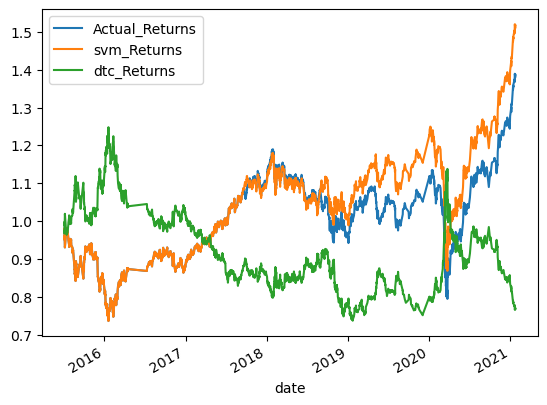

In [55]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df_2[["Actual_Returns", "svm_Returns","dtc_Returns"]]).cumprod().plot()